# EVENT PLOTS -- GUI version

A NB template to produce event plots (GUI version)

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-07 18:42:56


In [49]:
%gui qt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import sys
import os
import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from invisible_cities.database import load_db

In [5]:
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.sierpe.blr as blr
import invisible_cities.reco.peak_functions_c as cpf
from invisible_cities.core.mpl_functions import set_plot_labels
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units

In [28]:
from icaro.core.gui_functions import fplot_pmt_waveforms, fplot_pmt_signals_vs_time_mus, fplot_signal_vs_time_mus,\
                           fplot_s12, hist_1d, fplot_s2si_map, fill_col_vector, add_simap, fplot_map

In [7]:
from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si

In [8]:
from matplotlib.figure import Figure

### Import GUI

In [9]:
from qt_gui import QtGui

In [27]:
gui=QtGui()
gui.show()

#### Function scan_events loops over events and plots waveforms

In [84]:
def scan_events(epm, gui, input_files, xs, ys, plot=10, nmax=1000):  
                
    COL = []
    S1F = []
    S2F = []
    T= []
    
    n_events_tot = -1
    for ffile in input_files:
        print("Opening", ffile, end="... ")
        filename = ffile
        
        with tb.open_file(filename, "r") as h5rwf:
    
            pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
            NEVT, NPMT, PMTWL = pmtrwf.shape
            NEVT, NSIPM, SIPMWL = sipmrwf.shape
            print("""
            Number of events in file = {}
            Number of PMTs = {}
            PMTWL = {}
            Number of SiPMs = {}
            SiPMWL = {}
              """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))
            
            events = h5rwf.root.Run.events.col('evt_number')
            timestamp = h5rwf.root.Run.events.col('timestamp')
            
            
            for event, evt_number in enumerate(events):
                T.append(timestamp[event])
                n_events_tot +=1
                if n_events_tot == nmax:
                    gui.add_figure('Si-map-for-{}-events'.format(nmax), fplot_map(COL, xs, ys))
                    return T, S1F, S2F

                if(n_events_tot%plot == 0):
                    print('++++++processing event number {} with absolute number {}'.format(event, evt_number))
        
                epm.calibrated_pmt_and_csum(event, pmtrwf)
                epm.calibrated_sipm(event, sipmrwf)
                epm.find_s1()
                epm.find_s2()
                S1F.append(epm.s1f)
                S2F.append(epm.s2f)
                if (len(epm.S2) > 0):
                    epm.find_s2si()
                    add_simap(epm.S2Si, xs, COL)
            
                if(n_events_tot%plot == 0):
                    print('--S1 search')
                    print_s12(epm.S1)
                    print('--S2 search')
                    print_s12(epm.S2)
                    print('--S2Si search')
                    print_s2si(epm.S2Si)
        
               
                    gui.add_figure('RWF-event-{}'.format(event), 
                                fplot_pmt_waveforms(epm.RWF, zoom=False, window_size=10000))
                    gui.add_figure('CWF_vs_time_mus-event-{}'.format(event), 
                                fplot_pmt_signals_vs_time_mus(epm.CWF,
                                                         epm.P.pmt_active,
                                                         t_min      =    0,
                                                         t_max      = 1300,
                                                         signal_min =    -5,
                                                         signal_max =  300))
            
                    gui.add_figure('Calibrated_SUM-event-{}'.format(event), 
                                fplot_signal_vs_time_mus(epm.csum, 
                                                     t_min=0, 
                                                     t_max=1300, 
                                                     signal_min=-5, 
                                                     signal_max=350))
                    if (len(epm.S1) > 0):
                        gui.add_figure('S1-event-{}'.format(event), fplot_s12(epm.S1))
                
                    if (len(epm.S2) > 0):
                        gui.add_figure('S2-event-{}'.format(event), fplot_s12(epm.S2))
                        gui.add_figure('Si-map-event-{}'.format(event), fplot_s2si_map(epm.S2Si, xs, ys))
    
    print('adding Si-map')
    gui.add_figure('Si-map', fplot_map(COL, xs, ys))
    return T, S1F, S2F
            

## Define here the  events to analyze

### Krypton

1. Run 3389

Start Date     End Date     Duration (sec)

2017-03-23 20:52:16     2017-03-25 11:22:54     138638

trigger rate: 4.65 evt/s

events: 645.505

Trigger in 5 pmts with:

1. baseline dev: 15
2. max amplitude: 1000
3. qmin: 3000
4. qmax: 20000
5. min time: 4us
6. max time: 12us

#### PMAPS for Kr

### Na-22

1. Run 3574, 3575
2. Threshold baseline 20 counts
3. Qmin = 90,0000 counts
4. width min > 7 mus
5. 5 PMTs / 11

#### PMAPS parameters Na-22

### Alphas

1. run_number = 3452

#### PMAPS parameters for alphas

s1par  = S12Params(tmin=0*units.mus, tmax=650*units.mus, lmin=10, lmax=30, stride=4, rebin=False)
s2par = S12Params(tmin=630*units.mus, tmax=800*units.mus, stride=40, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=10 * units.pes,  thr_s2=10 *units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 30 * units.adc)

## Chose events to analyze

#### event type: na-22

In [30]:
run_number = 3609

In [47]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

#### Define selection parameters for PMAPS

In [48]:
s1par  = S12Params(tmin=0*units.mus, tmax=600*units.mus, lmin=5, lmax=20, stride=4, rebin=False)
s2par = S12Params(tmin=645*units.mus, tmax=1300*units.mus, stride=160, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=3 * units.pes,  thr_s2=1 *units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 30 * units.adc)

#### Instance of EventPmaps, events to analyze, sample and print

#### Files

In [42]:
input_dir = os.path.join(os.environ['IC_DATA'],
                'LSC/wvfms/{}'.format(run_number))
files_in = glob.glob(os.path.join(input_dir,'*.h5'))
files_in.sort()

In [44]:
files_in

['/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3609/run_3609.gdc1next.next-new.135.rd_3609.root.h5',
 '/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3609/run_3609.gdc1next.next-new.136.rd_3609.root.h5',
 '/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3609/run_3609.gdc1next.next-new.137.rd_3609.root.h5',
 '/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3609/run_3609.gdc1next.next-new.138.rd_3609.root.h5',
 '/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3609/run_3609.gdc1next.next-new.139.rd_3609.root.h5']

### Run!

Opening /Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3609/run_3609.gdc1next.next-new.135.rd_3609.root.h5... 
            Number of events in file = 82
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
              
++++++processing event number 0 with absolute number 22142
--S1 search
number of peaks = 0
--S2 search
number of peaks = 1
S12 number = 0, samples = 47 sum in pes =202257.29642625444
time vector (mus) = [ 649.96875     651.0125      652.0125      653.0125      654.0125
  655.0125      656.0125      657.0125      658.0125      659.0125
  660.0125      661.0125      662.0125      663.0125      664.0125
  665.0125      666.0125      667.0125      668.0125      669.0125
  670.0125      671.0125      672.0125      673.0125      674.0125
  675.0125      676.0125      677.0125      678.0125      679.0125
  680.0125      681.0125      682.0125      683.0125      684.0125
  685.0125      686.0125      687.0125  

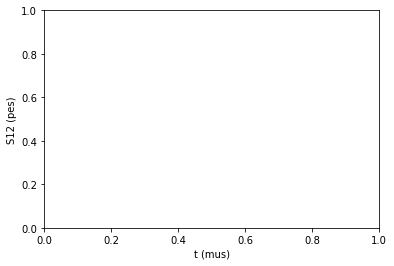

In [93]:
n_events = 100
plot = 1
gui=QtGui()
gui.show()
epm = EventPmaps(run_number, s1par, s2par, thr, verbose=False)
t0 = time.time()
T, S1F, S2F = scan_events(epm, gui, files_in, xs, ys, plot=plot, nmax=n_events)
t1 = time.time()        
dt = t1 - t0
print("run {} events in {} s event/s = {}".format(n_events, dt, dt/n_events))

In [94]:
S1F

[{},
 {0: S12Features(tmin=565375.0, tmax=565675.0, tpeak=565475.0, etot=152.46700079038712, epeak=25.215144112484467, width=300.0)},
 {},
 {0: S12Features(tmin=500550.0, tmax=500825.0, tpeak=500650.0, etot=274.2447645656369, epeak=51.354007378995775, width=275.0)},
 {0: S12Features(tmin=476475.0, tmax=476650.0, tpeak=476525.0, etot=94.072692958042438, epeak=18.262480995091568, width=175.0)},
 {},
 {0: S12Features(tmin=592500.0, tmax=592750.0, tpeak=592600.0, etot=137.14420263937569, epeak=25.072674054642228, width=250.0)},
 {0: S12Features(tmin=593200.0, tmax=593325.0, tpeak=593250.0, etot=55.642207320387755, epeak=12.368659211475848, width=125.0)},
 {},
 {},
 {},
 {0: S12Features(tmin=501875.0, tmax=502150.0, tpeak=501975.0, etot=203.83457037683655, epeak=33.099137789758359, width=275.0)},
 {0: S12Features(tmin=494225.0, tmax=494475.0, tpeak=494300.0, etot=348.4380173477731, epeak=62.279414340911501, width=250.0)},
 {0: S12Features(tmin=560275.0, tmax=560425.0, tpeak=560350.0, etot=8

In [95]:
T

[1491516947638,
 1491516948423,
 1491516948734,
 1491516949982,
 1491516950865,
 1491516951470,
 1491516952882,
 1491516955140,
 1491516956482,
 1491516958203,
 1491516960908,
 1491516961872,
 1491516962289,
 1491516964097,
 1491516964684,
 1491516965053,
 1491516965972,
 1491516966493,
 1491516967116,
 1491516967935,
 1491516969451,
 1491516969784,
 1491516971430,
 1491516972358,
 1491516973694,
 1491516974787,
 1491516976002,
 1491516977363,
 1491516977827,
 1491516978478,
 1491516979495,
 1491516981059,
 1491516982681,
 1491516983378,
 1491516983740,
 1491516985813,
 1491516986782,
 1491516986997,
 1491516989820,
 1491516990342,
 1491516992076,
 1491516993792,
 1491516994351,
 1491516994989,
 1491516995832,
 1491516997154,
 1491516997626,
 1491516999054,
 1491517000190,
 1491517003878,
 1491517004852,
 1491517006215,
 1491517007568,
 1491517007880,
 1491517009975,
 1491517011011,
 1491517013186,
 1491517014677,
 1491517016056,
 1491517016458,
 1491517017496,
 1491517019803,
 1491517

In [96]:
S2F

[{0: S12Features(tmin=649968.75, tmax=696443.18181818177, tpeak=686012.5, etot=202257.29642625444, epeak=14558.530616757422, width=46474.431818181765)},
 {0: S12Features(tmin=650256.875, tmax=669538.33333333337, tpeak=655262.5, etot=111390.8497670319, epeak=13409.538012061101, width=19281.458333333372),
  1: S12Features(tmin=677224.375, tmax=685552.5, tpeak=681487.5, etot=16323.784674113045, epeak=4597.0535445534715, width=8328.125)},
 {0: S12Features(tmin=650480.0, tmax=668366.66666666663, tpeak=660487.5, etot=96087.024955021145, epeak=12325.043180662611, width=17886.666666666628)},
 {0: S12Features(tmin=649225.625, tmax=709380.95238095243, tpeak=659287.5, etot=134121.45673911792, epeak=10454.014634277566, width=60155.327380952425),
  1: S12Features(tmin=817326.25, tmax=840345.0, tpeak=823687.5, etot=8901.417723150018, epeak=1314.621203655533, width=23018.75)},
 {0: S12Features(tmin=649752.5, tmax=666521.875, tpeak=658787.5, etot=62680.567188011672, epeak=11707.084990006637, width=167

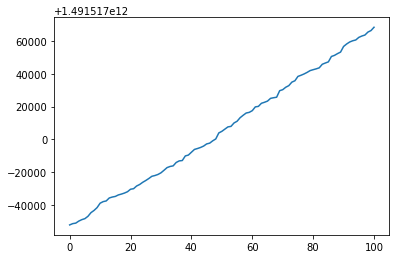

In [97]:
plt.plot(T)